In [1]:
# Author: Samantha Tetef
# Created: 4.19.21
# Title: GP_BUCB_Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor

## Testing UCB1, GP-UCG, and  GP-BUCB algorithms

### Creating synthetic data

In [3]:
N = 1000
X = np.linspace(0,1,N)

# parameter space
coeffs = np.linspace(-3,3,21)
print(f"Possible coeffs: {coeffs}")

# all possible actions
Action_Set = np.array(list(itertools.product(coeffs, repeat=3)))
num_permutes = Action_Set.shape[0]
print(f"Actions set shappe: {Action_Set.shape}")

Possible coeffs: [-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7  3. ]
Actions set shappe: (9261, 3)


In [4]:
Y = np.zeros((num_permutes,N))
# targets are polynomial using actions as coeffs
for i in range(num_permutes):
    Y[i,:] = Action_Set[i,0]*X**2 + Action_Set[i,1]*X + Action_Set[i,2]

# adding normal noise for variation
noise = np.random.normal(loc=0.0, scale=0.1, size=(num_permutes,N))
Y = Y + noise

print(Y.shape)

(9261, 1000)


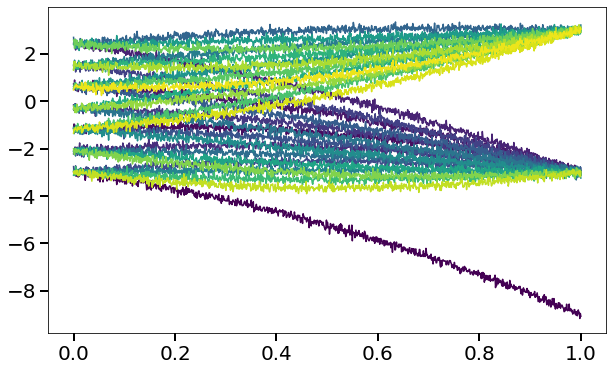

In [5]:
# displaying data
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

Colors= plt.cm.viridis(np.arange(num_permutes)/(num_permutes+1))

for i in range(num_permutes):
    if not i % 300:
        plt.plot(X, Y[i], '-', c=Colors[i], label=f'${Action_Set[i,0]}x^2+{Action_Set[i,1]}x+{Action_Set[i,1]}$')

plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

# plt.legend(fontsize=fontsize)
plt.show()

In [6]:
# create wanted "target"
target_action = (-1.7, 0.1, 0.1)
target = target_action[0]*X**2 + target_action[1]*X + target_action[2]

In [7]:
def MSE(Y, target):
    return np.sum((Y-target)**2, axis=1)/Y.shape[0]

In [8]:
mse = np.round(MSE(Y, target), 1)

In [17]:
# create dataframe
columns = ['a', 'b', 'c']
df = pd.DataFrame(data=Action_Set, columns=columns)
df['MSE'] = mse
# df['index'] = np.arange(len(Action_Set))
df

,a,b,c,MSE
0,-3.0,-3.0,-3.0,3.0
1,-3.0,-3.0,-2.7,2.6
2,-3.0,-3.0,-2.4,2.3
3,-3.0,-3.0,-2.1,2.1
4,-3.0,-3.0,-1.8,1.8
...,...,...,...,...
9256,3.0,3.0,1.8,2.9
9257,3.0,3.0,2.1,3.3
9258,3.0,3.0,2.4,3.6
9259,3.0,3.0,2.7,3.9


In [34]:
def ucb1_policy(df, t, batch_size, ucb_scale=2.0):
    '''
    Applies GP-BUCB policy to generate recommendations.
    
    This is adapted from the tutorial found at
    https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/
    
    Arguments:
        df - dataset on which to apply UCB policy
            type == dataframe
        t - current time step (start at 1)
            type == int
        ucb_scale - the scale of the upper bound
            default = 2.0
            type == float
    Returns:
        actions - a subset of the data with the highest ucb
            type == dataframe        
    '''
    summary_df = df.groupby('MSE')
    summary_df = summary_df.agg(['mean', 'count', 'std'])
    columns = ['a', 'b', 'c']
    for colm in columns: 
        summary_df['ucb'] = summary_df[(colm, 'mean')] \
            + ucb_scale * summary_df[(colm, 'std')] / np.sqrt(summary_df[(colm, 'count')])
    scores = summary_df.sort_values('ucb', ascending=False)
    
    recs = scores.loc[scores.index[:batch_size].values, (columns, 'mean')]
    return recs

recomendations = ucb1_policy(df, 1, 3)
recomendations

,a,b,c
,mean,mean,mean
MSE,,,
3.0,1.735714,1.907143,2.292857
3.7,2.500000,2.700000,2.900000
3.9,2.900000,2.700000,2.900000
